# Data Augmentation using Imgaug

Reference : https://blog.csdn.net/u012897374/article/details/80142744


In [1]:
import PIL.Image as Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
dpi = matplotlib.rcParams['figure.dpi']

def plt_show_img(img):
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

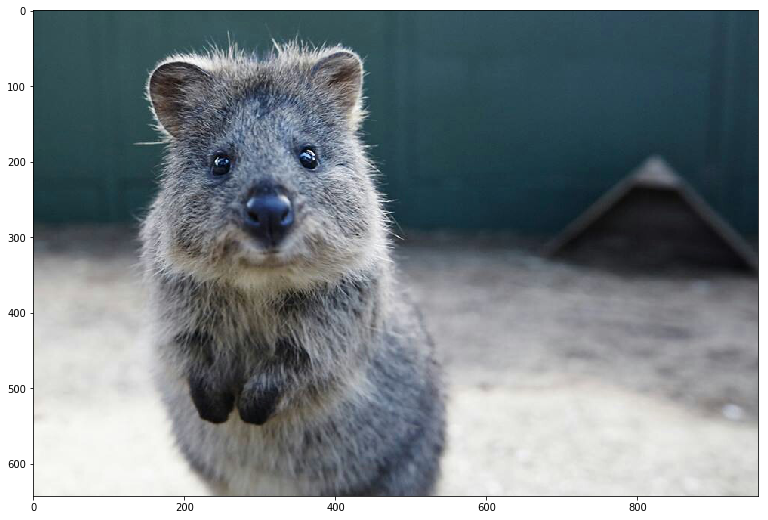

In [3]:
# Build-in test image
img = ia.quokka()
plt_show_img(img)

PIL 讀圖會需要用 ap.array(Img) 將之轉成numpy 可以顯示的照片

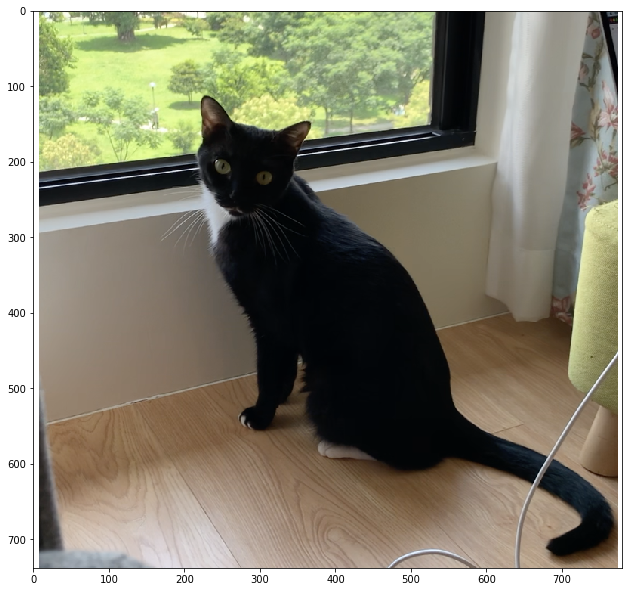

In [4]:
# Load image
file_name = "./assets/cv_data_1.png"
img = Image.open(file_name, mode='r')
img = img.convert('RGB')
img = np.array(img)
plt_show_img(img)


## Simple augmentation

In [5]:
# Basic usage
ia.seed(1) #定義隨機參數
seq = iaa.Sequential([
    iaa.Crop(px=(100, 160)), # crop images from each side by 100 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0.0, 3.0)) # blur images with a sigma of 0 to 3.0
])

C:\Users\Evan\Anaconda3\lib\site-packages\imgaug\augmenters\segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  image, n_segments=n_segments_samples[i], compactness=10)


維度增加一維(256, 256, 3)


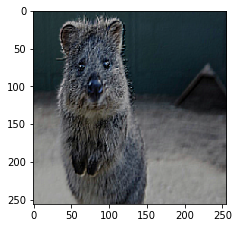

維度增加一維(256, 256, 3)


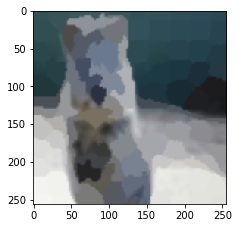

維度增加一維(256, 256, 3)


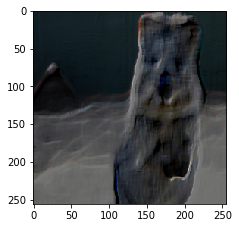

In [26]:
# Apply aug
images_aug = seq(images=[img, img, img]) #將三張圖疊在一起

for img_a in images_aug:
    print(f'維度增加一維{img_a.shape}')
    plt_show_img(img_a)


## Heavy augmentation

In [28]:
# Advanced usage
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))), #有百分之50的機會被使用

    iaa.SomeOf((0, 5), #從以下變換中選取 0-5 個來使用
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
            ],
            # do all of the above augmentations in random order
            random_order=True #每次使用的順序不宜(有可能第一個變換先取
        )
], random_order=True) # apply augmenters in random order

(256, 256, 3)


C:\Users\Evan\Anaconda3\lib\site-packages\imgaug\augmenters\segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  image, n_segments=n_segments_samples[i], compactness=10)


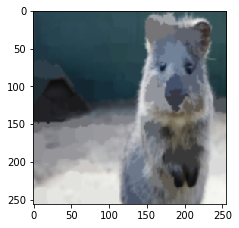

(256, 256, 3)


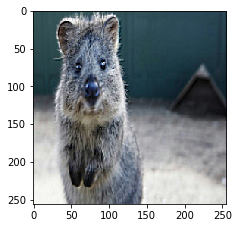

(256, 256, 3)


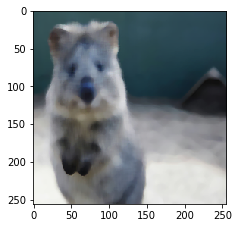

In [29]:
# Apply aug
images_aug = seq(images=[img, img, img])

for img_a in images_aug:
    print(img_a.shape)
    plt_show_img(img_a)


---

## Bounding Box

In [9]:
# Define bounding box
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

bb1 = BoundingBox(x1=230, y1=120, x2=550, y2=600)
bb2 = BoundingBox(x1=10, y1=80, x2=350, y2=300)
bbs = BoundingBoxesOnImage([bb1, bb2], shape=img.shape)

BB 0: (230.0000, 120.0000, 550.0000, 600.0000) -> (287.7899, 207.6855, 572.2101, 634.3159)
BB 1: (10.0000, 80.0000, 350.0000, 300.0000) -> (92.2510, 172.1330, 394.4475, 367.6719)


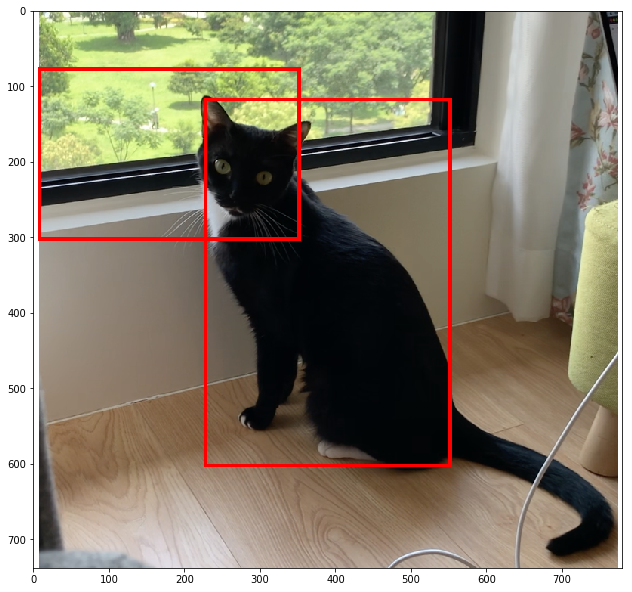

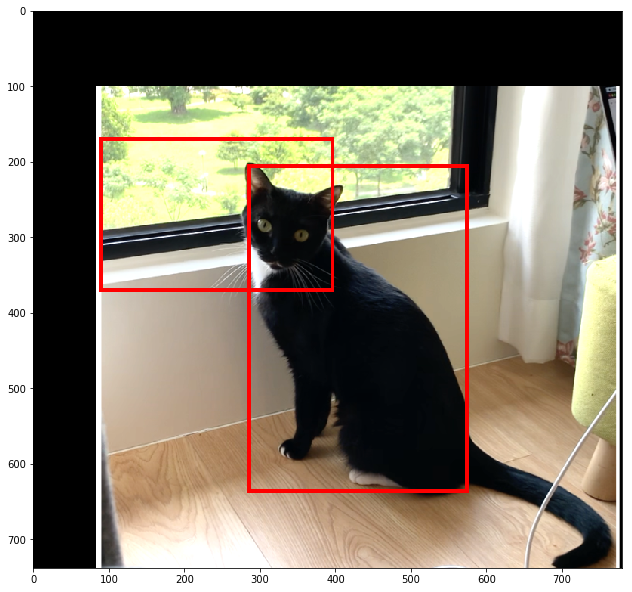

In [10]:
seq_1 = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.8, 1)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

# Augment BBs and images.
image_aug, bbs_aug = seq_1(image=img, bounding_boxes=bbs) #將 BB 直接印在圖上

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(img, size=5, color=[255, 0, 0])
plt_show_img(image_before)

image_after = bbs_aug.draw_on_image(image_aug, size=5, color=[255, 0, 0])
plt_show_img(image_after)


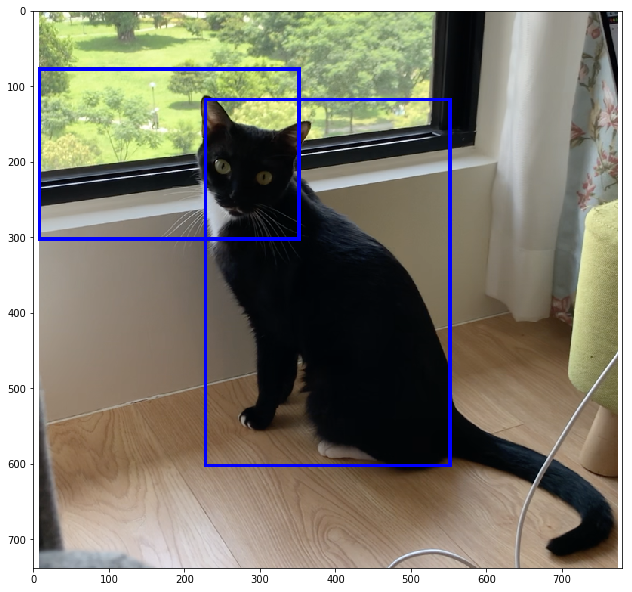

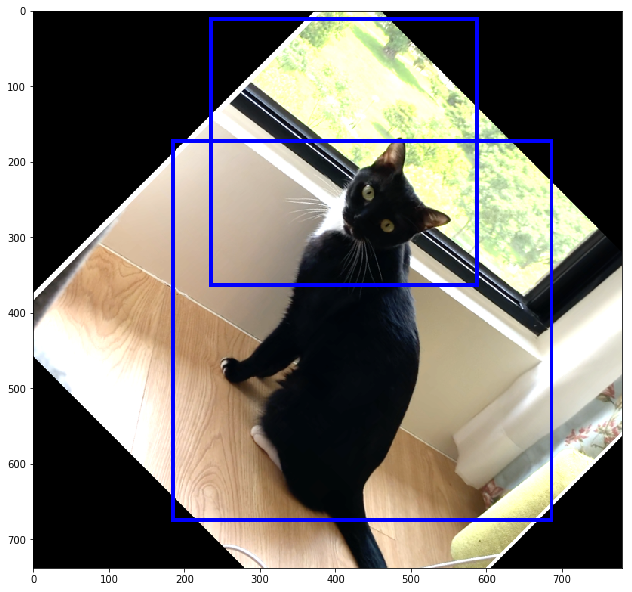

In [11]:
seq_2 = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.8, 1),
        rotate=45
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

image_aug, bbs_aug = seq_2(image=img, bounding_boxes=bbs)

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(img, size=5, color=[0, 0, 255])
plt_show_img(image_before)

image_after = bbs_aug.draw_on_image(image_aug, size=5, color=[0, 0, 255])
plt_show_img(image_after)

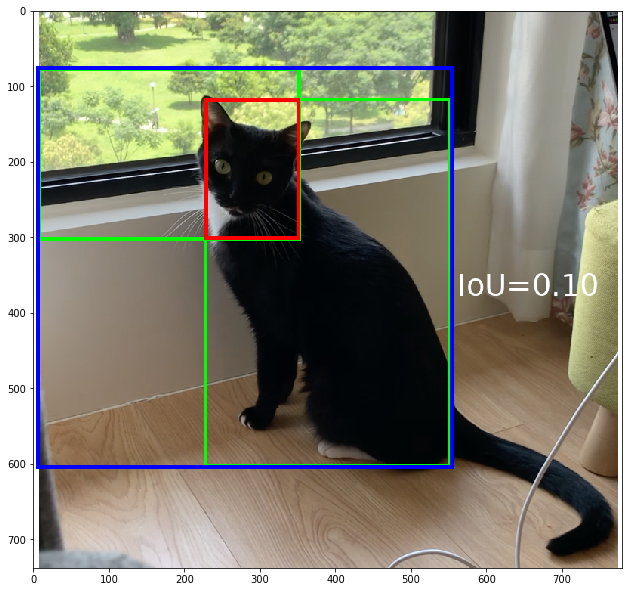

In [12]:
# Compute intersection, union and IoU value
# Intersection and union are both bounding boxes. They are here
# decreased/increased in size purely for better visualization.
bb_inters = bb1.intersection(bb2).extend(all_sides=-1) #內縮一個pixel 比較好看
bb_union = bb1.union(bb2).extend(all_sides=2)
iou = bb1.iou(bb2)

# Draw bounding boxes, intersection, union and IoU value on image.
image_bbs = np.copy(img)
image_bbs = bb1.draw_on_image(image_bbs, size=5, color=[0, 255, 0])
image_bbs = bb2.draw_on_image(image_bbs, size=5, color=[0, 255, 0])
image_bbs = bb_inters.draw_on_image(image_bbs, size=5, color=[255, 0, 0])
image_bbs = bb_union.draw_on_image(image_bbs, size=5, color=[0, 0, 255])
image_bbs = ia.draw_text(
    image_bbs, text="IoU=%.2f" % (iou,),
    x=bb_union.x2+10, y=bb_union.y1+bb_union.height//2,
    color=[255, 255, 255], size=40
)
plt_show_img(image_bbs)

## Practice

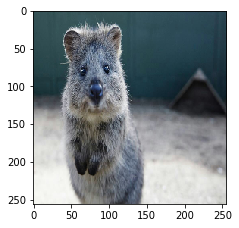

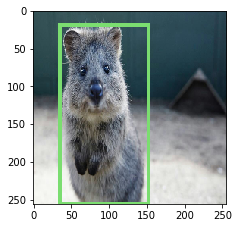

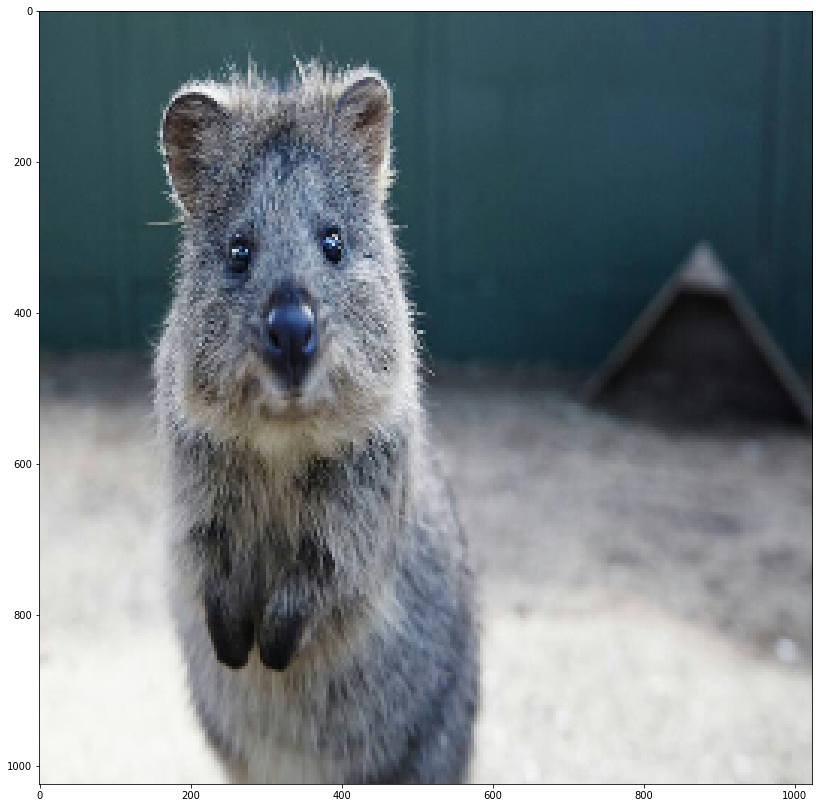

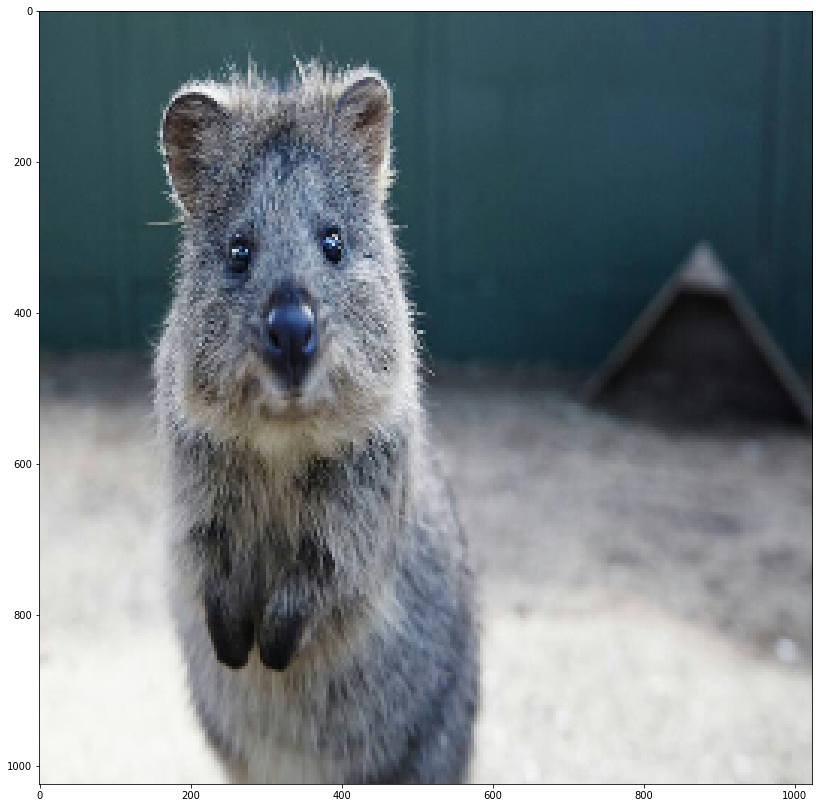

In [79]:
# 1. Load image
img = ia.quokka(size=(256, 256))
plt_show_img(img)

# 2. Define 1 bbox
bb1 = BoundingBox(x1=37, y1=21, x2=150, y2=254)
bbs = BoundingBoxesOnImage([bb1], shape=img.shape)

# 3. Draw bbox on org image
img_new = bbs.draw_on_image(img, size=5, color=[123, 221, 112])
plt_show_img(img_new)

# 4. Resize image to 1000*1000 (hint: ia.imresize_single_image)
img_resize = ia.imresize_single_image(img, 1024)
plt_show_img(img_resize)


# 5. "Project" bbox on resized image (hint: imgaug.augmentables.bbs.project)
bb1_pro = bb1.project((256,256), (1024,1024))
bbs_new = BoundingBoxesOnImage([bb1_pro], shape=img_resize.shape)
# 6. Draw projected bbox on resized image
img_new = bbs_new.draw_on_image(img_resize, size=5, color=[123, 221, 112])

plt_show_img(img_resize)
